In [1]:
# lib
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

import torch
import torch.nn as nn
import numpy as np
import torch.optim as optim
import torch.nn.functional as F

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
from torch.utils.data import Dataset, DataLoader, random_split
from PIL import Image
import matplotlib.pyplot as plt

In [2]:
# load
class AbdomenCT(torch.utils.data.Dataset):
    def __init__(self, images_dir, masks_dir):
        self.transform = A.Compose([
            A.Resize(256, 256),  # original(3,512,512)
            # A.HorizontalFlip(),  # x-axis
            # A.VerticalFlip(),  # y-axis
            A.ElasticTransform(p=0.1),
            A.Normalize(),  # normalization
            ToTensorV2(),
        ])
        self.ids = os.listdir(images_dir)
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids]
        self.masks_fps = [os.path.join(masks_dir, mask_id) for mask_id in self.ids]
        
    def __getitem__(self, i):
        # read data
        image = np.array(Image.open(self.images_fps[i]).convert('RGB'))
        mask = np.array(Image.open(self.masks_fps[i]).convert('RGB'))
        image = self.transform(image=image, mask=mask)
        return image['image'], image['mask'][:,:,0]
    
    def __len__(self):
        return len(self.ids)

image_dir = os.path.join('/kaggle/input/abdomenct/image')
mask_dir = os.path.join('/kaggle/input/abdomenct/mask')

dataset = AbdomenCT(image_dir, mask_dir)
trainset, validset = random_split(dataset, [450, 50])

train_loader = DataLoader(dataset=trainset, batch_size=5, shuffle=True)
valid_loader = DataLoader(dataset=validset, batch_size=5, shuffle=True)
# (org)image_size: torch.Size([5, 3, 256, 256]), mask_size: torch.Size([5, 256, 256])

In [3]:
# net
# ‘SAME’: padding = (kernel_size-stride)/2
class Encoder(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(Encoder, self).__init__()
        self.layer = nn.Sequential(
            nn.Conv2d(in_channels=in_ch, out_channels=out_ch,
                      kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, 1, 1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
        )
        self.down = nn.MaxPool2d(kernel_size=2, stride=2)
        
    def forward(self, x):
        """
        : param x: input
        : return: out1(deep_layer),out2(next_layer)
        """
        out1 = self.layer(x)
        out2 = self.down(out1)    
        return out1, out2

    
class Decoder(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(Decoder, self).__init__()
        self.layer = nn.Sequential(
            nn.Conv2d(in_channels=in_ch, out_channels=out_ch,
                      kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, 1, 1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
        )
        self.up = nn.Upsample(scale_factor=2, mode='bilinear')
        
    def forward(self, x, out1):
        """
        : param x: input former layer
        : param out1: shallow layer
        """
        x = self.up(x)
        out = torch.cat((x, out1), dim=1)  # concatenation
        out = self.layer(out)
        return out
    
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        channels = [64, 128, 256, 512, 1024]
        
        # contract
        self.d1 = Encoder(3, channels[0])  # 3-64-64
        self.d2 = Encoder(channels[0], channels[1])  # 64-128-128
        self.d3 = Encoder(channels[1], channels[2])  # 128-256-256
        self.d4 = Encoder(channels[2], channels[3])  # 256-512-512
        
        # neck
        self.nk = nn.Sequential(
            nn.Conv2d(in_channels=channels[3], out_channels=channels[4],
                      kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(channels[4]),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=channels[4], out_channels=channels[4],
                      kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(channels[4]),
            nn.ReLU(inplace=True),
        )  # 512-1024-1024
        
        # expansive
        self.u4 = Decoder(channels[4]+channels[3], channels[3])  # 1024-512-512
        self.u3 = Decoder(channels[3]+channels[2], channels[2])  # 512+256-256-256
        self.u2 = Decoder(channels[2]+channels[1], channels[1])  # 256+128-128-128
        self.u1 = Decoder(channels[1]+channels[0], channels[0])  # 128+64-64-64
        
        # segmentation
        self.so = nn.Sequential(
            nn.Conv2d(in_channels=channels[0], out_channels=1, kernel_size=1, stride=1, padding=0),  # 64-1
            nn.Sigmoid(),
        )
        
    def forward(self, x):
        outd1, out = self.d1(x)
        outd2, out = self.d2(out)
        outd3, out = self.d3(out)
        outd4, out = self.d4(out)
        
        out = self.nk(out)
        
        out = self.u4(out, outd4)
        out = self.u3(out, outd3)
        out = self.u2(out, outd2)
        out = self.u1(out, outd1)
        
        out = self.so(out)
        
        return out

In [4]:
# loss
class DiceBCELoss(nn.Module):
    # without loss descend
    def __init__(self):
        super(DiceBCELoss, self).__init__()
        # BCEWithLogitsLoss: sigmoid+BCELoss
        self.bce = nn.BCELoss()
        
    def forward(self, inputs, targets, smooth=1):
        targets = torch.sigmoid(targets)
        # flatten label and prediction
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs*targets).sum()
        union = inputs.sum() + (targets.sum())
        dice_loss = 1 - ((2*intersection+smooth)/(union+smooth))
        bce_loss = self.bce(inputs, targets)
        loss = dice_loss + bce_loss
        return loss

class IoU(nn.Module):
    def __init__(self):
        super(IoU, self).__init__()
        
    def forward(self, inputs, targets, smooth=0.1, threshold=0.3):
        # flatten label and prediction
        targets = torch.sigmoid(targets)
        inputs = inputs.view(-1)
        targets = targets.view(-1)

        tempinputs = inputs.detach().cpu()
        temptargets = targets.detach().cpu()
        
        temptargets[np.nonzero(temptargets<=threshold)] = 0.0
        temptargets[np.nonzero(temptargets>threshold)] = 1.0
        # print(tempinputs, temptargets)
        intersection = (tempinputs*temptargets).sum()
        union = tempinputs.sum() + temptargets.sum()
        iou = (intersection+smooth)/(union-intersection+smooth)
        # print(intersection, union, iou)
        return iou

In [5]:
# train, test
def trainer(model, train_loader, valid_loader, criterion, optimizer, iou, epochs):
    
    loss_hist, train_hist, valid_hist = [],[],[]
    best_acc = 0
    for epoch in range(epochs):
        print('epoch{}/{}'.format(epoch+1, epochs))
        model.train()
        losses, train_iou, valid_iou = [],[],[]
        for image, mask in train_loader:
            image = image.to(device, dtype=torch.float)
            mask = mask.to(device, dtype=torch.float)
            pred = model.forward(image)
            
            trainpiou = iou(pred,mask)
            loss = criterion(pred, mask)
            
            losses.append(loss.item())
            train_iou.append(trainpiou.detach().cpu())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        model.eval()
        with torch.no_grad():
            for image, mask in valid_loader:
                image = image.to(device)
                mask = mask.to(device)
                pred = model.forward(image)
                validpiou = iou(pred, mask)
                
            valid_iou.append(validpiou.detach().cpu())
            if epoch == (epochs-1):
                img = image.detach().cpu()
                msk = mask.detach().cpu()
                prd = pred.detach().cpu()
                
                prd = torch.squeeze(prd)
                prd_size = prd.shape
                prd = prd.view(-1)
                prd[np.nonzero(prd<=0.7)] = 0.0
                prd[np.nonzero(prd>0.7)] = 1.0
                prd = prd.reshape(prd_size)
        
        loss_hist.append(np.mean(losses))
        train_hist.append(np.mean(train_iou))
        valid_hist.append(np.mean(valid_iou))
        print('loss:{}'.format(loss_hist[-1]))
        print('Train Accuracy:{}'.format(train_hist[-1]))
        print('Validation Accuracy:{}'.format(valid_hist[-1]))
        
        if valid_hist[-1] > best_acc:
            print(f'Best model found at epoch {epoch+1}, saving model')
            torch.save(model.state_dict(), 'AbdomenCT_unet.pt')
            best_acc = valid_hist[-1]
        
    return loss_hist, train_hist, valid_hist, img, msk, prd


def plot_model_hist(train_hist, valid_hist, loss_hist):
    x = np.arange(len(train_hist))
    
    fig = plt.figure(figsize=(10,6))
    plt.plot(x, train_hist, label='train_dice')
    plt.plot(x, valid_hist, label='valid_dice')
    plt.plot(x, loss_hist, label='train_loss')
    
    plt.title('unet', fontsize=15)
    plt.legend(fontsize=12)
    plt.xlabel('Epoch')
    plt.ylabel('IoU/Loss')
    
    plt.show()

epoch1/100
loss:1.0198108017444611
Train Accuracy:0.6325264573097229
Validation Accuracy:0.6325464844703674
Best model found at epoch 1, saving model
epoch2/100
loss:0.9972985313998328
Train Accuracy:0.6378517746925354
Validation Accuracy:0.6303166747093201
epoch3/100
loss:0.9911951435936822
Train Accuracy:0.6373753547668457
Validation Accuracy:0.6317194700241089
epoch4/100
loss:0.9890747639867995
Train Accuracy:0.6366444230079651
Validation Accuracy:0.6331736445426941
Best model found at epoch 4, saving model
epoch5/100
loss:0.9850456204679278
Train Accuracy:0.6357904076576233
Validation Accuracy:0.6188091039657593
epoch6/100
loss:0.9829475111431546
Train Accuracy:0.635717511177063
Validation Accuracy:0.6425113081932068
Best model found at epoch 6, saving model
epoch7/100
loss:0.9805527753300137
Train Accuracy:0.6347326636314392
Validation Accuracy:0.6328341960906982
epoch8/100
loss:0.976750730143653
Train Accuracy:0.6348541378974915
Validation Accuracy:0.6301303505897522
epoch9/100
l

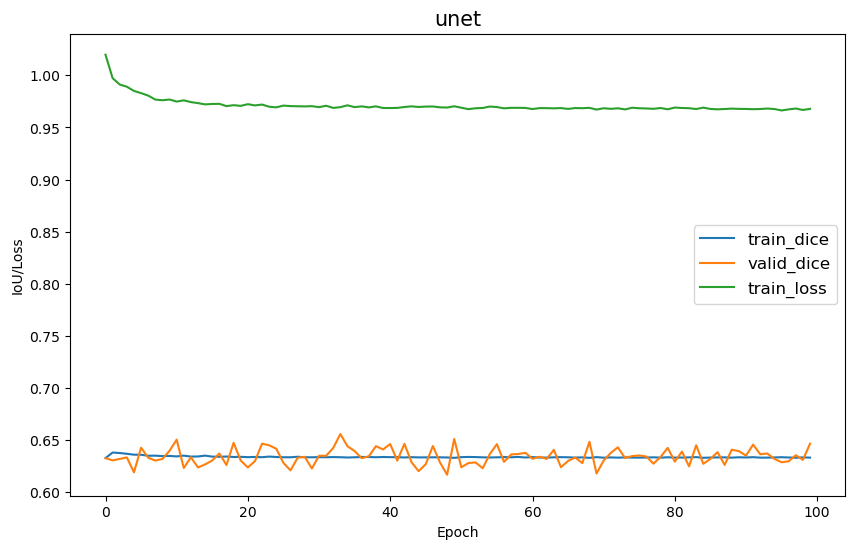

In [6]:
# run
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = UNet().to(device)
criterion = DiceBCELoss()
iou = IoU()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
epochs = 100

loss_hist, train_hist, valid_hist, img1, msk1, prd1 = trainer(model, train_loader, valid_loader, criterion, optimizer, iou, epochs)
print('last 20 average of validation accuracy:{}'.format(sum(valid_hist[-1:-21:-1])/20))
plot_model_hist(train_hist, valid_hist, loss_hist)

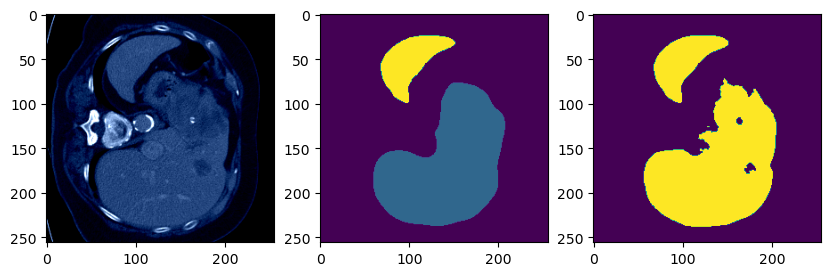

In [7]:
plt.figure(figsize=(10,10))
plt.subplot(131)
plt.imshow((img1[0,:,:,:].moveaxis(0,2)))
plt.subplot(132)
plt.imshow(msk1[0,:,:])
plt.subplot(133)
plt.imshow(prd1[0,:,:])

plt.show()